## Import Libraries

In [117]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model persistence
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [118]:
df = pd.read_csv('../data/process/superstore_with_features.csv')

print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

df.info()


Dataset Shape: 9994 rows × 26 columns
Memory Usage: 10.75 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   ob

In [119]:
# Check for missing values
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
Year             0
Month            0
Quarter          0
DayOfWeek        0
Delivery_Days    0
dtype: int64

In [120]:
# Check for duplicates
df.duplicated().sum()

0

In [121]:
# Check for outliers in numerical columns
numerical_cols = ['Sales', 'Quantity', 'Discount', 'Profit']

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = (len(outliers) / len(df)) * 100
    
    print(f"\n{col}:")
    print(f"  • Outliers: {len(outliers)} ({outlier_pct:.2f}%)")
    print(f"  • Range: [{lower_bound:.2f}, {upper_bound:.2f}]")


Sales:
  • Outliers: 1167 (11.68%)
  • Range: [-271.71, 498.93]

Quantity:
  • Outliers: 170 (1.70%)
  • Range: [-2.50, 9.50]

Discount:
  • Outliers: 856 (8.57%)
  • Range: [-0.30, 0.50]

Profit:
  • Outliers: 1881 (18.82%)
  • Range: [-39.72, 70.82]


## Feature Engineering


In [122]:
# Convert 'Order Date' and 'Ship Date' to datetime at eda before
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product Name,Sales,Quantity,Discount,Profit,Year,Month,Quarter,DayOfWeek,Delivery_Days
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2013,11,4,5,3
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2013,11,4,5,3
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2013,6,2,3,4
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2012,10,4,3,7
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2012,10,4,3,7


In [123]:
# Create profit margin feature
df['Profit_Margin'] = (df['Profit'] / df['Sales']) * 100

# Handle potential division by 0
df['Profit_Margin'] = df['Profit_Margin'].replace([np.inf, -np.inf], 0)

print(f"\nProfit Margin Statistics:")
print(f"  • Mean: {df['Profit_Margin'].mean():.2f}%")
print(f"  • Median: {df['Profit_Margin'].median():.2f}%")
print(f"  • Min: {df['Profit_Margin'].min():.2f}%")
print(f"  • Max: {df['Profit_Margin'].max():.2f}%")


Profit Margin Statistics:
  • Mean: 12.03%
  • Median: 27.00%
  • Min: -275.00%
  • Max: 50.00%


In [124]:
# Additional feature engineering
df['Sales_Per_Quantity'] = df['Sales'] / df['Quantity']
df['Is_Discounted'] = (df['Discount'] > 0).astype(int)
df['High_Value_Transaction'] = (df['Sales'] > df['Sales'].quantile(0.75)).astype(int)

print("\nNew features:")
print("  • Sales_Per_Quantity: Average price per item")
print(df['Sales_Per_Quantity'].head())

print("\n  • Is_Discounted: Binary flag for discounted items")
print(df['Is_Discounted'].head())

print("\n  • High_Value_Transaction: Binary flag for high-value sales")
print(df['High_Value_Transaction'].head())

print(f"\nDiscounted transactions: {df['Is_Discounted'].sum()} ({(df['Is_Discounted'].sum()/len(df)*100):.1f}%)")
print(f"High-value transactions: {df['High_Value_Transaction'].sum()} ({(df['High_Value_Transaction'].sum()/len(df)*100):.1f}%)")


New features:
  • Sales_Per_Quantity: Average price per item
0    130.9800
1    243.9800
2      7.3100
3    191.5155
4     11.1840
Name: Sales_Per_Quantity, dtype: float64

  • Is_Discounted: Binary flag for discounted items
0    0
1    0
2    0
3    1
4    1
Name: Is_Discounted, dtype: int32

  • High_Value_Transaction: Binary flag for high-value sales
0    1
1    1
2    0
3    1
4    0
Name: High_Value_Transaction, dtype: int32

Discounted transactions: 5196 (52.0%)
High-value transactions: 2498 (25.0%)


## Feature Selection for Modeling

In [125]:
features_to_keep = [
    # Categorical features
    'Segment', 'Region', 'Category', 'Sub-Category',
    # Numerical features
    'Sales', 'Quantity', 'Discount',
    # Time features
    'Year', 'Month', 'Quarter', 'DayOfWeek', 'Delivery_Days',
    # Engineered features
    'Profit_Margin', 'Sales_Per_Quantity', 'Is_Discounted', 'High_Value_Transaction',
    # Target
    'Profit'
]

df_model = df[features_to_keep].copy()

print(f"\nTotal features: {len(features_to_keep) - 1}")
print(f"Target variable: Profit")
print(f"Dataset shape: {df_model.shape}")

print("\nFeature :")
categorical = ['Segment', 'Region', 'Category', 'Sub-Category']
print(f"  • Categorical: {len(categorical)}")
print(f"  • Numerical: {len(features_to_keep) - len(categorical) - 1}")

df_model.head()



Total features: 16
Target variable: Profit
Dataset shape: (9994, 17)

Feature :
  • Categorical: 4
  • Numerical: 12


,Segment,Region,Category,Sub-Category,Sales,Quantity,Discount,Year,Month,Quarter,DayOfWeek,Delivery_Days,Profit_Margin,Sales_Per_Quantity,Is_Discounted,High_Value_Transaction,Profit
0,Consumer,South,Furniture,Bookcases,261.9600,2,0.00,2013,11,4,5,3,16.00,130.9800,0,1,41.9136
1,Consumer,South,Furniture,Chairs,731.9400,3,0.00,2013,11,4,5,3,30.00,243.9800,0,1,219.5820
2,Corporate,West,Office Supplies,Labels,14.6200,2,0.00,2013,6,2,3,4,47.00,7.3100,0,0,6.8714
3,Consumer,South,Furniture,Tables,957.5775,5,0.45,2012,10,4,3,7,-40.00,191.5155,1,1,-383.0310
4,Consumer,South,Office Supplies,Storage,22.3680,2,0.20,2012,10,4,3,7,11.25,11.1840,1,0,2.5164


## Encode Categorical Variables

In [126]:
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    
    print(f"\n{col}:")
    print(f"  • Unique values: {len(le.classes_)}")
    print(f"  • Classes: {le.classes_[:5]}...") 

print(f"\nTotal encoders created: {len(label_encoders)}")



Segment:
  • Unique values: 3
  • Classes: ['Consumer' 'Corporate' 'Home Office']...

Region:
  • Unique values: 4
  • Classes: ['Central' 'East' 'South' 'West']...

Category:
  • Unique values: 3
  • Classes: ['Furniture' 'Office Supplies' 'Technology']...

Sub-Category:
  • Unique values: 17
  • Classes: ['Accessories' 'Appliances' 'Art' 'Binders' 'Bookcases']...

Total encoders created: 4


In [127]:
print("\nEncoded Dataset Sample:")
df_model.head(10)


Encoded Dataset Sample:



,Segment,Region,Category,Sub-Category,Sales,Quantity,Discount,Year,Month,Quarter,DayOfWeek,Delivery_Days,Profit_Margin,Sales_Per_Quantity,Is_Discounted,High_Value_Transaction,Profit
0,0,2,0,4,261.9600,2,0.00,2013,11,4,5,3,16.00,130.9800,0,1,41.9136
1,0,2,0,5,731.9400,3,0.00,2013,11,4,5,3,30.00,243.9800,0,1,219.5820
2,1,3,1,10,14.6200,2,0.00,2013,6,2,3,4,47.00,7.3100,0,0,6.8714
3,0,2,0,16,957.5775,5,0.45,2012,10,4,3,7,-40.00,191.5155,1,1,-383.0310
4,0,2,1,14,22.3680,2,0.20,2012,10,4,3,7,11.25,11.1840,1,0,2.5164
5,0,3,0,9,48.8600,7,0.00,2011,6,2,3,5,29.00,6.9800,0,0,14.1694
6,0,3,1,2,7.2800,4,0.00,2011,6,2,3,5,27.00,1.8200,0,0,1.9656
7,0,3,2,13,907.1520,6,0.20,2011,6,2,3,5,10.00,151.1920,1,1,90.7152
8,0,3,1,3,18.5040,3,0.20,2011,6,2,3,5,31.25,6.1680,1,0,5.7825
9,0,3,1,1,114.9000,5,0.00,2011,6,2,3,5,30.00,22.9800,0,0,34.4700


## Train-Test Split

In [128]:
X = df_model.drop('Profit', axis=1)
y = df_model['Profit']

# (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df_model)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df_model)*100:.1f}%)")

print(f"\nTarget Variable (Profit) Statistics:")
print("\nTraining Set:")
print(f"  • Mean: ${y_train.mean():.2f}")
print(f"  • Median: ${y_train.median():.2f}")
print(f"  • Std: ${y_train.std():.2f}")
print(f"  • Min: ${y_train.min():.2f}")
print(f"  • Max: ${y_train.max():.2f}")

print("\nTest Set:")
print(f"  • Mean: ${y_test.mean():.2f}")
print(f"  • Median: ${y_test.median():.2f}")
print(f"  • Std: ${y_test.std():.2f}")
print(f"  • Min: ${y_test.min():.2f}")
print(f"  • Max: ${y_test.max():.2f}")


Training set: 7995 samples (80.0%)
Test set: 1999 samples (20.0%)

Target Variable (Profit) Statistics:

Training Set:
  • Mean: $30.70
  • Median: $8.64
  • Std: $237.60
  • Min: $-6599.98
  • Max: $8399.98

Test Set:
  • Mean: $20.50
  • Median: $8.69
  • Std: $220.25
  • Min: $-3839.99
  • Max: $3177.47


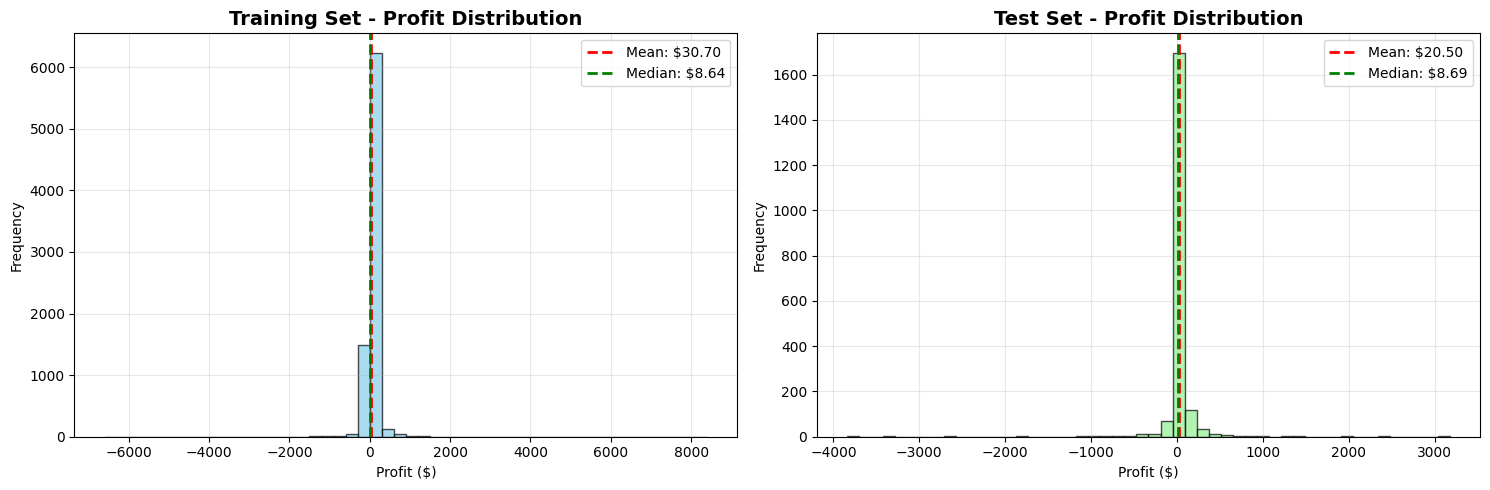

In [129]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].hist(y_train, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${y_train.mean():.2f}')
axes[0].axvline(y_train.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${y_train.median():.2f}')
axes[0].set_title('Training Set - Profit Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Profit ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].hist(y_test, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${y_test.mean():.2f}')
axes[1].axvline(y_test.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${y_test.median():.2f}')
axes[1].set_title('Test Set - Profit Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Profit ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Preprocessed Data and Objects

In [130]:
# Save train-test datasets to CSV
X_train.to_csv('../data/split/X_train.csv', index=False)
X_test.to_csv('../data/split/X_test.csv', index=False)
y_train.to_csv('../data/split/y_train.csv', index=False)
y_test.to_csv('../data/split/y_test.csv', index=False)

print("✅ Train-test datasets saved:")
print(f"  • X_train: {X_train.shape} → ../data/split/X_train.csv")
print(f"  • X_test: {X_test.shape} → ../data/split/X_test.csv")
print(f"  • y_train: {y_train.shape} → ../data/split/y_train.csv")
print(f"  • y_test: {y_test.shape} → ../data/split/y_test.csv")


✅ Train-test datasets saved:
  • X_train: (7995, 16) → ../data/split/X_train.csv
  • X_test: (1999, 16) → ../data/split/X_test.csv
  • y_train: (7995,) → ../data/split/y_train.csv
  • y_test: (1999,) → ../data/split/y_test.csv


In [131]:
# Save label encoders
with open('../models/label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

# Save feature names
feature_names = X.columns.tolist()
with open('../models/feature_names.pkl', 'wb') as file:
    pickle.dump(feature_names, file)

print(f"\nFeatures: {feature_names}")


Features: ['Segment', 'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Year', 'Month', 'Quarter', 'DayOfWeek', 'Delivery_Days', 'Profit_Margin', 'Sales_Per_Quantity', 'Is_Discounted', 'High_Value_Transaction']


## Preprocessing Summary

In [132]:
print("\nData Quality:")
print(f"  • Missing values: 0")
print(f"  • Duplicates removed: 0")

print("\nFeature Engineering:")
print(f"  • Time features: 5 (Year, Month, Quarter, DayOfWeek, Delivery_Days)")
print(f"  • Business features: 4 (Profit_Margin, Sales_Per_Quantity, Is_Discounted, High_Value_Transaction)")
print(f"  • Total features created: 9")

print("\nEncoding:")
print(f"  • Categorical variables encoded: {len(label_encoders)}")
print(f"  • Active categorical features: {list(label_encoders.keys())}")

print("\nData Split:")
print(f"  • Training samples: {len(X_train)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Features: {len(X.columns)}")

print("\nSaved Files:")
print(f"  • Pickle files: 2 (label_encoders.pkl, feature_names.pkl)")
print(f"  • CSV files: 4 ")



Data Quality:
  • Missing values: 0
  • Duplicates removed: 0

Feature Engineering:
  • Time features: 5 (Year, Month, Quarter, DayOfWeek, Delivery_Days)
  • Business features: 4 (Profit_Margin, Sales_Per_Quantity, Is_Discounted, High_Value_Transaction)
  • Total features created: 9

Encoding:
  • Categorical variables encoded: 4
  • Active categorical features: ['Segment', 'Region', 'Category', 'Sub-Category']

Data Split:
  • Training samples: 7995
  • Test samples: 1999
  • Features: 16

Saved Files:
  • Pickle files: 2 (label_encoders.pkl, feature_names.pkl)
  • CSV files: 4 
